In [ ]:
import xgboost as xgb

# setup

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from imblearn.under_sampling import RandomUnderSampler
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
from datetime import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jeremy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jeremy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train_set = pd.read_csv('./train_set_with_features.csv')

In [ ]:
jeremy_train = train_set

In [ ]:
jeremy_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404266 entries, 0 to 404265
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      404266 non-null  int64  
 1   qid1                    404266 non-null  int64  
 2   qid2                    404266 non-null  int64  
 3   question1               404266 non-null  object 
 4   question2               404264 non-null  object 
 5   is_duplicate            404266 non-null  int64  
 6   common_words_ratio      404266 non-null  float64
 7   common_tokens_ratio     404266 non-null  float64
 8   fuzz_partial_ratio      404266 non-null  int64  
 9   min_longest_substring   404266 non-null  float64
 10  unique_words_count      404266 non-null  int64  
 11  common_token_ratio_min  404266 non-null  float64
 12  fuzz_ratio              404266 non-null  int64  
 13  abs_len_difference      404266 non-null  int64  
 14  common_stop_words_mi

# glove embedding prep

In [ ]:
# populate embeddings_index dictionary for easy retrieval during sentence conversion
embeddings_index = {}
with open('../glove.840B.300d.txt', encoding='utf-8') as f:
  for line in f:
    values = line.split(' ')
    word = values[0]
    embedding = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = embedding

reference: how to convert glove embeddings to use for cosine distance

https://mlwhiz.com/blog/2019/02/08/deeplearning_nlp_conventional_methods/

In [ ]:
def convertToUnitVectorEmbedding(s):
    words = word_tokenize(s.lower())
    # remove stop words and only add words
    words = [embeddings_index[w] for w in words if not w in stop_words and w.isalpha() and w in embeddings_index]
    embeddings_np_arr = np.array(words)
    sentence_embedding = embeddings_np_arr.sum(axis=0)
    
    # in case an entire sentence is invalid, sum will return 0 (since embeddings are all 0)
    if sentence_embedding.all() == 0.0:
        return np.zeros(300)
    
    # convert to unit vector
    return sentence_embedding / np.sqrt((sentence_embedding ** 2).sum())

In [ ]:
from tqdm import tqdm_notebook
from scipy.spatial.distance import cosine

question1_vectors = np.zeros((jeremy_train.shape[0], 300))
for i, q in enumerate(tqdm_notebook(jeremy_train.question1.values)):
    question1_vectors[i, :] = convertToUnitVectorEmbedding(str(q))
    
question2_vectors  = np.zeros((jeremy_train.shape[0], 300))
for i, q in enumerate(tqdm_notebook(jeremy_train.question2.values)):
    question2_vectors[i, :] = convertToUnitVectorEmbedding(str(q))
    
# now to calc cosine distance
embed_col = []
for i in range(len(question1_vectors)):
    embed_col.append(cosine(np.nan_to_num(question1_vectors[i]), np.nan_to_num(question2_vectors[i])))
    
jeremy_train['embed_cos_dist'] = embed_col

# data preparation

In [ ]:
X = jeremy_train.drop(["is_duplicate","id","qid1","qid2","question1","question2"], axis=1)
y = jeremy_train.is_duplicate

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# normalise the data
standardScaler = StandardScaler()
X_processed = standardScaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

# do train test split before undersampling
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.2, random_state=42)

In [ ]:
# undersampling
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_under, y_under = undersample.fit_resample(X_train, y_train)
X_train = X_under
y_train = y_under

In [ ]:
# to check that train set is sampled
print("total y_train len: ", len(y_train))
print("1 labels in y_train: ", len([x for x in y_train if x == 1]))
print("0 labels in y_train: ", len([x for x in y_train if x == 0]))
print("")

# to check that test set is not sampled
print("total y_test len: ", len(y_test))
print("1 labels in y_test: ", len([x for x in y_test if x == 1]))
print("0 labels in y_test: ", len([x for x in y_test if x == 0]))

total y_train len:  239130
1 labels in y_train:  119565
0 labels in y_train:  119565

total y_test len:  80854
1 labels in y_test:  29698
0 labels in y_test:  51156


In [ ]:
# use DMatrix, which is supposedly more efficient for xgboost
train_dMatrix = xgb.DMatrix(X_train, label=y_train)
test_dMatrix = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# default parameters
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.2,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'binary:logistic',
    'eval_metric': "logloss"
}

# from trials, able to get min logloss before using up all 999 rounds, so set an arbitrarily large number as upper bound
num_boost_round = 999
early_stopping_rounds = 10
kfold_cv = 5

- `max_depth` determines the depth of the tree (affects overfitting)
- `min_child_weight` determines how many children needs to be in a class before the tree splits based on a certain feature
- `n_estimators` or `num_boost_rounds` determines how many sequential trees to correct an error made by previous trees
- `objective` set to binary logistic, since this is a binary classification problem.
- https://kevinvecmanis.io/machine%20learning/hyperparameter%20tuning/dataviz/python/2019/05/11/XGBoost-Tuning-Visual-Guide.html

# helper functions

In [ ]:
def cvNewParams(newParamDict):
    for key, value in newParamDict.items():
        params[key] = value

    # use xgboost's native cv function
    cv_results = xgb.cv(
        params,
        train_dMatrix,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=kfold_cv,
        metrics={'logloss'},
        early_stopping_rounds=early_stopping_rounds
    )
    
    # return minimum logloss from cv using current params
    min_logloss = float("Inf")
    for i in range(len(cv_results['test-logloss-mean'])):
        if cv_results['test-logloss-mean'][i] < min_logloss:
            min_logloss = cv_results['test-logloss-mean'][i]
            
    return min_logloss

# tuning max_depth and min_child_weight
- affects the depth of the xgboost trees and hence complexity and overfitting

In [ ]:
min_logloss = float("Inf")
best_params = None

for max_depth in range(8, 12):
    for min_child_weight in range(5, 8):
        mean_logloss = cvNewParams({'max_depth': max_depth, 'min_child_weight': min_child_weight})

        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_params = (max_depth, min_child_weight)

In [ ]:
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]
params

{'max_depth': 9,
 'min_child_weight': 5,
 'eta': 0.2,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss'}

# subsample

In [ ]:
min_logloss = float("Inf")
best_params = None

for subsample in range(8, 11):
    for colsample_bytree in range(8, 11):
        # use decimal to signify percentage
        mean_logloss = cvNewParams({'subsample': subsample/10, 'colsample_bytree': colsample_bytree/10})
        
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_params = (subsample/10, colsample_bytree/10)

In [ ]:
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]
params

{'max_depth': 9,
 'min_child_weight': 5,
 'eta': 0.2,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss'}

# tuning eta i.e. learning rate

In [ ]:
eta_values = [.2, .1, .05, 0.01]

In [ ]:
best_params = None

for eta in eta_values:
    mean_logloss = cvNewParams({'eta': eta})
    
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = eta

In [ ]:
params['eta'] = best_params

# final params

In [ ]:
params

{'max_depth': 9,
 'min_child_weight': 5,
 'eta': 0.05,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss'}

In [ ]:
model = xgb.train(
    params,
    train_dMatrix,
    num_boost_round=num_boost_round,
    evals=[(test_dMatrix, "testset")],
    early_stopping_rounds=early_stopping_rounds
)

In [ ]:
model.save_model("xgboost.model")

In [ ]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.load_model("xgboost.model")

eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_cl.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

preds = xgb_cl.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

print("accuracy", accuracy_score(y_test, preds))
print("precision", precision_score(y_test, preds)) 
print("recall", recall_score(y_test, preds)) 
print("f1", f1_score(y_test, preds))
print(classification_report(y_test, preds))

accuracy 0.7366240383901848
precision 0.5974396437765255
recall 0.8674321503131524
f1 0.7075545545683013
              precision    recall  f1-score   support

           0       0.90      0.66      0.76     51156
           1       0.60      0.87      0.71     29698

    accuracy                           0.74     80854
   macro avg       0.75      0.76      0.73     80854
weighted avg       0.79      0.74      0.74     80854



plot graph
- https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

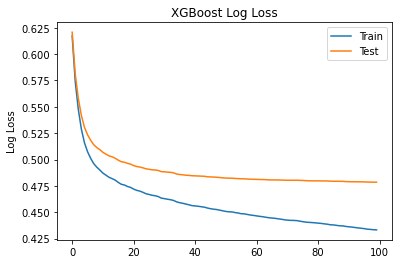

In [ ]:
import matplotlib.pyplot as pyplot

results = xgb_cl.evals_result()
boost_rounds = len(results['validation_0']['error'])
x_axis = range(0, boost_rounds)
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label="Train")
ax.plot(x_axis, results['validation_1']['logloss'], label="Test")
ax.legend()
pyplot.ylabel("Log Loss")
pyplot.title("XGBoost Log Loss")
pyplot.show()

# what is XGBoost

iteratively combines predictions of several weak learners e.g. decision trees to produce a more robust model

# advantages/disadvantages of xgboost

- advantages:
  - allows for parallel processing
  - easy cross validation built in

- disadvantages:
  - need to feature engineer to extract the correct data, hence might not be very good for NLP models as we have to extract our own features. without prior experience in NLP/linguistics, it can be hard to extract good features from the data set.

referenced sources:

https://kevinvecmanis.io/machine%20learning/hyperparameter%20tuning/dataviz/python/2019/05/11/XGBoost-Tuning-Visual-Guide.html

https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

## exporting dataset with word embeddings

In [ ]:
X_train_with_headers = pd.DataFrame(X_train, columns = X.columns)

y_train_with_headers = pd.Series(y_train, name = 'is_duplicate')
y_train_with_headers = y_train_with_headers.to_frame()

full_train_set = pd.concat([X_train_with_headers, y_train_with_headers], axis=1)
full_train_set.to_csv("full_train.csv")

In [ ]:
X_test_with_headers = pd.DataFrame(X_test, columns = X.columns)

y_test_with_headers = pd.DataFrame(data = y_test, columns = ['is_duplicate'])

full_test_set = pd.concat([X_test_with_headers, y_test_with_headers], axis=1)
full_test_set.to_csv("full_test.csv")